## Tutorial on integrating ReaktoroBlock into RO unit model on a flowsheet
Demonstration of how use Reaktoro block with a unit model from WaterTAP

#### Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling
* cyipopt - Solver necessary for use with gray box models
* Reaktoro-pse - Python package for building Reaktoro gray box models
* watertap-solvers - for cyipopt solver wrapper
* WaterTAP - Unit models

### Demonstration structure 
* Setting up basic speciation block and calculating properties for a feed composition
    * How to adjust apparent species to achieve thermodynamic equilibrium
* Adding Reaktoro block to a [RO WaterTAP](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/reverse_osmosis_1D.html) model for calculation of local osmotic pressure and scaling tendency


### Example for speciation of NaCl and use with RO model

### Import needed modules

In [1]:
## Import core components
# Pyomo core components
from pyomo.environ import (
    Var,
    Constraint,
    TransformationFactory,
    Reals,
    ConcreteModel,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from pyomo.network import Arc

# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import (
    calculate_scaling_factors,
    set_scaling_factor,
    constraint_scaling_transform,
)

from idaes.core.util.model_statistics import degrees_of_freedom
from watertap_solvers import get_solver

from idaes.core.util.initialization import propagate_state

from idaes.models.unit_models import Feed
from pyomo.util.calc_var_value import calculate_variable_from_constraint

# WaterTAP core components
from watertap.property_models.NaCl_prop_pack import NaClParameterBlock

# WaterTAP core components
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock

# Import reaktoro-pse and reaktoro
from reaktoro_pse.reaktoro_block import ReaktoroBlock
import reaktoro

### Incorporating Reaktoro to calculate Seawater properties in Reverse Osmosis Desalination
Sea water desalination is a common process. Here it is demonstrated how ReaktoroBlock can be used:
 1) Calculate feed density, achieve charge neutrality, and estimate amount of acid need to operate at target pH
 2) Calculate osmotic pressure on each node of 1D WaterTAP RO model

In [2]:
# This a typical composition of sea water with ion concentration in mg/L and pH

sea_water_composition = {
    "Na": 10556,
    "K": 380,
    "Ca": 400,
    "Mg": 1262,
    "Cl": 17000,
    "SO4": 2649,
    "HCO3": 140,
}
sea_water_ph = 7.56

### Define standard Pyomo model and WaterTAP property package

In [3]:
m = ConcreteModel()
# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)
# can use NaCl or Sea water prop pack
prop_pack = "Seawater"
if prop_pack == "Seawater":
    # create NaCl property model
    m.fs.properties = SeawaterParameterBlock()
    bulk_ion = "TDS"
elif prop_pack == "NaCl":
    m.fs.properties = NaClParameterBlock()
    bulk_ion = "NaCl"
else:
    raise TypeError(f"{prop_pack} is not valid")
# build feed
m.fs.feed = Feed(property_package=m.fs.properties)

### Define inputs for Reaktoro and outputs
The NaCl and Sea water prop package does not track spiceies so we will create new variable sets to track thesese as well as needed outputs

In [4]:
# Get ions
ions = list(sea_water_composition.keys())
#
m.fs.feed.species_concentrations = Var(
    ions, initialize=1, bounds=(0, None), units=pyunits.mg / pyunits.L
)

# ReaktoroBlock needs mass flows of all the species
ions.append("H2O")
m.fs.feed.species_mass_flow = Var(
    ions, initialize=1, bounds=(0, None), units=pyunits.kg / pyunits.s
)

# Create pH variable for feed
m.fs.feed.pH = Var(initialize=sea_water_ph)
m.fs.feed.pH.fix()

# The solution is not charge neutralized, so to get true TDS, we will need to adjust concentration of one of the ions"""
m.fs.feed.reaktoro_charge = Var(initialize=0, bounds=(None, None))
set_scaling_factor(m.fs.feed.reaktoro_charge, 1e8)

# To get true flow mass, the density is needed for the solution, we can get that from reaktoro
m.fs.feed.reaktoro_density = Var(
    initialize=1000, units=pyunits.kg / pyunits.m**3
)  # default density unit returned by reaktoro - https://reaktoro.org/api/classReaktoro_1_1ChemicalProps.html#afd97c7985258fa29f5a69634c07a0ac7

# We can also get osmotic pressure to compare to NaCl prop pack predictions, and pH after acid addition
m.fs.feed.reaktoro_osmotic_pressure = Var(initialize=1, units=pyunits.Pa)
m.fs.feed.reaktoro_adjusted_pH = Var(initialize=1, units=pyunits.dimensionless)

# We will want to add a dose of acid to the feed to drop the pH to typical operating point of RO
m.fs.acid_dose = Var(initialize=0, units=pyunits.mg / pyunits.L)
m.fs.acid_mass_flow = Var(
    initialize=0, units=pyunits.kg / pyunits.s
)  # Reaktoro will use mass flow as input!

### Writing constraints for calculation of mass flows

In [5]:
# Write constraints to convert concentration to mass flows


@m.fs.feed.Constraint(list(m.fs.feed.species_mass_flow.keys()))
def eq_feed_species_mass_flow(fs, ion):
    if ion == "H2O":
        return (
            m.fs.feed.species_mass_flow["H2O"]
            == m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"]
        )
    else:
        """calculate mass flow based on density"""
        return m.fs.feed.species_mass_flow[ion] == pyunits.convert(
            m.fs.feed.species_concentrations[ion]
            * m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", "H2O")]
            / m.fs.feed.reaktoro_density,
            to_units=pyunits.kg / pyunits.s,
        )


# Need NaCl for the NaCl property package in watertap
m.fs.feed.eq_NaCl = Constraint(
    expr=m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", bulk_ion)]
    == sum(m.fs.feed.species_mass_flow[ion] for ion in m.fs.feed.species_concentrations)
)

# Calculate acid dose
m.fs.eq_acid_dose = Constraint(
    expr=m.fs.acid_mass_flow
    == pyunits.convert(
        m.fs.acid_dose
        * m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", "H2O")]
        / m.fs.feed.reaktoro_density,
        to_units=pyunits.kg / pyunits.s,
    )
)

### Reaktoro Block output dict

In [6]:
"""We need to define an output dictionary with our properties - this can also be an Pyomo IndexedVar please check examples in examples folder for how to use IndexedVars as outputs"""

m.fs.feed.reaktoro_outputs = {
    (
        "pH",
        None,
    ): m.fs.feed.reaktoro_adjusted_pH,  # the "None" in second index is defined to indicate its a system property rather then specific component
    (
        "osmoticPressure",
        "H2O",
    ): m.fs.feed.reaktoro_osmotic_pressure,  # not how the second key is the water, we can get osmotic pressure for different components in the system
    ("density", None): m.fs.feed.reaktoro_density,
    ("charge", None): m.fs.feed.reaktoro_charge,
    "speciesAmount": True,
}  # - this will force reaktor to return exact speciation with all species

### Configure ReaktoroBlock
We are dealing with seawater desalination, which implies operation at high salinity and pressure for such conditions the PhreeqC Pitzer data base is a good choice 
For comparison of PhreeqC data base following paper is a good reference: https://doi.org/10.1016/j.earscirev.2021.103888 

In [7]:
from reaktoro_pse.reaktoro_block_config import reaktoro_solver_options


m.fs.feed.reaktoro_properties = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.feed.species_mass_flow,  # This is the spices mass flow
        "convert_to_rkt_species": True,  # We can use default converter as its defined for default database (Phreeqc and pitzer)
        "activity_model": reaktoro.ActivityModelPitzer(),  # Can provide a string, or Reaktoro initialized class
        "fixed_solvent_specie": "H2O",  # We need to define our aqueous solvent as we have to speciate the block
    },
    system_state={
        "temperature": m.fs.feed.properties[0].temperature,
        "pressure": m.fs.feed.properties[0].pressure,
        "pH": m.fs.feed.pH,
    },
    outputs=m.fs.feed.reaktoro_outputs,  # outputs we desired
    chemistry_modifier={
        "HCl": m.fs.acid_mass_flow
    },  # here we define that we are adding 'HCL' as acid and its mass flow
    database="PhreeqcDatabase",  # Can provide a string, or Reaktoro initialized class reaktor.PhreeqcDatabase()
    database_file="pitzer.dat",  # needs to be a string that names the database file or points to its location
    dissolve_species_in_reaktoro=True,  # This will sum up all species into elements in Reaktoro directly, if set to false, it will build Pyomo constraints instead
    assert_charge_neutrality=False,  # This is True by Default, but here we actually want to adjust the input speciation till the charge is zero
    reaktoro_solve_options={
        "open_species_on_property_block": [
            "H+",
            "OH-",
        ]
    },  # This option helps stabilize Reaktoro by providing redundant constraints and generally does not impact final solution.
    build_speciation_block=True,  # We provided apparent species so we need to speciate them.
)

2025-03-25 14:16:28 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2025-03-25 14:16:28 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2025-03-25 14:16:28 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using BFGS hessian type
2025-03-25 14:16:28 [WARNING] idaes.reaktoro_pse.core.reaktoro_inputs: Registered an empty constraint for ['H+', 'OH-'], this can lead to unexpected results depending on reaktoro configuration, please use with caution
2025-03-25 14:16:28 [WARNING] idaes.reaktoro_pse.core.reaktoro_inputs: Registered an empty constraint for ['H+', 'OH-'], this can lead to unexpected results depending on reaktoro configuration, please use with caution
2025-03-25 14:16:28 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using BFGS hessian type


Lets inspect outputs from main reaktoro model

Note how we are missing osmoticPressure, and instead have speciesActivityLn and speciesStandardVolume as our outputs, this is becouse we osmoticPressure is a pyomo property, rather a native property supplied by reaktoro. You can inspect how this property is created by checking the:
* osmoticPressure in PyomoProperties class located in reaktoro_pse.core.reaktoro_outputs
* build_osmotic_constraint in reaktoro_pse.core.pyomo_property_writer.property_functions

This two location will also show how we can access reaktoro database to pull out fixed parameters and create a custom pyomo property. 

In [8]:
m.fs.feed.reaktoro_properties.reaktoro_model.outputs.display()

outputs : Size=21, Index=fs.feed.reaktoro_properties.reaktoro_model._output_names_set
    Key                              : Lower : Value : Upper : Fixed : Stale : Domain
                    ('charge', None) :  None :   0.1 :  None : False : False :  Reals
                   ('density', None) :  None :   0.1 :  None : False : False :  Reals
                        ('pH', None) :  None :   0.1 :  None : False : False :  Reals
        ('speciesActivityLn', 'H2O') :  None :   0.1 :  None : False : False :  Reals
            ('speciesAmount', 'CO2') :  None :   0.1 :  None : False : False :  Reals
          ('speciesAmount', 'CO3-2') :  None :   0.1 :  None : False : False :  Reals
           ('speciesAmount', 'Ca+2') :  None :   0.1 :  None : False : False :  Reals
            ('speciesAmount', 'Cl-') :  None :   0.1 :  None : False : False :  Reals
             ('speciesAmount', 'H+') :  None :   0.1 :  None : False : False :  Reals
            ('speciesAmount', 'H2O') :  None :   0.1 :

### Set default values for feed and scaling

In [9]:
m.fs.feed.properties[0].temperature.fix(273 + 25)  # temperature (K)
m.fs.feed.properties[0].pressure.fix(101325)  # pressure (Pa)
m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"].fix(
    0.965
)  # mass flowrate of H2O (kg/s)
m.fs.feed.properties[0].conc_mass_phase_comp[...]  # construct concentration props
m.fs.feed.properties[0].pressure_osm_phase[...]
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1 / 0.965,
    index=("Liq", "H2O"),
)
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1 / 0.035,  # aproximage scale
    index=("Liq", bulk_ion),
)

### Initialize our composition constraints and scale all the variables

In [10]:
for ion, value in sea_water_composition.items():
    m.fs.feed.species_concentrations[ion].fix(value)
    set_scaling_factor(m.fs.feed.species_concentrations[ion], 1 / value)

for comp, pyoobj in m.fs.feed.eq_feed_species_mass_flow.items():
    calculate_variable_from_constraint(m.fs.feed.species_mass_flow[comp], pyoobj)
    set_scaling_factor(
        m.fs.feed.species_mass_flow[ion], 1 / m.fs.feed.species_mass_flow[comp].value
    )
    constraint_scaling_transform(pyoobj, 1 / m.fs.feed.species_mass_flow[comp].value)


calculate_variable_from_constraint(
    m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", bulk_ion)], m.fs.feed.eq_NaCl
)
constraint_scaling_transform(m.fs.feed.eq_NaCl, 1 / 0.035)

set_scaling_factor(m.fs.feed.reaktoro_density, 1 / 1000)
set_scaling_factor(m.fs.feed.reaktoro_osmotic_pressure, 1 / 1e5)
set_scaling_factor(m.fs.feed.reaktoro_adjusted_pH, 1)
set_scaling_factor(m.fs.feed.pH, 1)
set_scaling_factor(m.fs.acid_mass_flow, 1e2)
set_scaling_factor(m.fs.acid_dose, 1e-3)
set_scaling_factor(m.fs.feed.reaktoro_charge, 1e8)

### Intialize feed and reaktoro block. 
Reaktoro initialization does several steps:

1) Initialize input constraints propagating them from user variables to Reaktoro graybox inputs
2) Solve the Reaktoro block to get output properties 
3) Propagate Reaktoro solution through output constraints and to output variables 
4) Scale all input and output variables and constraints using either user provided scaling factors or by inverse of their value 
5) Scale the jacobian using user provided scaling or inverse of scaling factors of the gray box outputs

This will in general provide a well scaled problem. 

In [11]:
solver = get_solver()  # get solver
m.fs.feed.initialize(optarg=solver.options)
m.fs.feed.reaktoro_properties.initialize()
# this is our exact composition!
m.fs.feed.reaktoro_properties.outputs.display()

# and these are manually defined properties and variables of interest
print(
    "Density reaktoro",
    m.fs.feed.reaktoro_density.value,
    f"Density {prop_pack} pack",
    m.fs.feed.properties[0].dens_mass_phase["Liq"].value,
)
print(
    "Osmotic pressure",
    m.fs.feed.reaktoro_osmotic_pressure.value,
    f"Density {prop_pack} pack",
    m.fs.feed.properties[0].pressure_osm_phase["Liq"].value,
)
print("Adjusted pH", m.fs.feed.reaktoro_adjusted_pH.value)
print("Solution reaktoro_charge", m.fs.feed.reaktoro_charge.value)

2025-03-25 14:16:28 [INFO] idaes.init.fs.feed.properties: fs.feed.properties State Released.
2025-03-25 14:16:28 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-03-25 14:16:28 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing speciation block fs.feed.reaktoro_properties----
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.feed.reaktoro_properties----
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
outputs : Size=15, Index={('speciesAmount', 'SO4-2'), ('speciesAmount', 'K+'), ('speciesAmount', 'CO2'), ('speciesAmount', 'HSO4-'), ('speciesAmount', 'Na+'), ('speciesAmount', 'Mg+2'), ('speciesAmount',

D:\github\reaktoro-pse\src\reaktoro_pse\core\reaktoro_jacobian.py:346: RuntimeWarning: invalid value encountered in divide
  jac_val = np.average(diff / step)


We can check the jacobian scaling using provided tool, it will also return a dictionary with scaling factors. 

In [12]:
jac_scaling_dict = m.fs.feed.reaktoro_properties.display_jacobian_scaling()

2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for speciation block ------
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'H+') : 3.69804041447456e-08, IDX: 0
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'H2O') : 53.563499111900505, IDX: 1
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'CO3-2') : 2.1445433578637304e-05, IDX: 2
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'CO2') : 8.11468696171412e-05, IDX: 3
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'Ca+2') : 0.009631002164385663, IDX: 4
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'Cl-') : 0.4627181

In [13]:
m.fs.feed.reaktoro_properties.display_jacobian_outputs()

2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for speciation block ------
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: -----displaying jacobian outputs and types-----
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H+'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H2O'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'CO3-2'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'CO2'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'Ca+2'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'Cl-'): Jac type: exact
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H

## Updating Jacobian scaling 
In some cases we need to manually scale output Jacobian values, as they can get overscaled via automatic scaling.
This can be done during creating of ReaktoroBlock by passing "jacobian_user_scaling" option with a dictionary of output indexes and scaling factor to apply. In some cases it might be more convenient to update scaling factor later.

Example below shows updating scaling factor using built in function set_jacboian_scaling, the scaling will be applied to both speciation block (if built) and main block


In [14]:
m.fs.feed.reaktoro_properties.update_jacobian_scaling({("density", None): 1000})

### Inspect reakotor states

In [15]:
m.fs.feed.reaktoro_properties.display_reaktoro_state()

2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for speciation block ------
2025-03-25 14:16:29 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for property block ------


### Lets solve the current model to:
* Find actual mass flows of species 
* Solution density
* Required Cl amount to get zero charge in solution
* Dose of HCl ot get to pH of 7

In [16]:
# unfix Cl and fix charge to 0

m.fs.feed.species_concentrations["Cl"].unfix()
m.fs.feed.reaktoro_charge.fix(0)
# fix our target pH
m.fs.feed.reaktoro_adjusted_pH.fix(7)

Lets check DOFs before solve, and note that its equal to number of our reaktoro outputs

In [17]:
print("DOFs:", degrees_of_freedom(m))
assert degrees_of_freedom(m)== 0

DOFs: 0


In [18]:
initial_cl = m.fs.feed.species_concentrations["Cl"].value
cy_solver = get_solver(solver="cyipopt-watertap")

cy_solver.options["max_iter"] = 25

result = cy_solver.solve(m, tee=True)
assert_optimal_termination(result)

cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling


D:\github\reaktoro-pse\src\reaktoro_pse\core\reaktoro_jacobian.py:346: RuntimeWarning: invalid value encountered in divide
  jac_val = np.average(diff / step)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      749
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       14

Total number of variables............................:      118
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:      118
Total number of inequality c

In [19]:
print(
    "Density reaktoro",
    m.fs.feed.reaktoro_density.value,
    f"Density {prop_pack} pack",
    m.fs.feed.properties[0].dens_mass_phase["Liq"].value,
)
print(
    "Osmotic pressure",
    m.fs.feed.reaktoro_osmotic_pressure.value,
    f"Density {prop_pack} pack",
    m.fs.feed.properties[0].pressure_osm_phase["Liq"].value,
)
print(
    "Adjusted pH",
    m.fs.feed.reaktoro_adjusted_pH.value,
    "Acid dose",
    m.fs.acid_dose.value,
    "Acid mass flow",
    m.fs.acid_mass_flow.value,
)
print(
    "Solution reaktoro_charge",
    m.fs.feed.reaktoro_charge.value,
    "intial Cl",
    initial_cl,
    "final Cl",
    m.fs.feed.species_concentrations["Cl"].value,
)

Density reaktoro 1022.4474912371847 Density Seawater pack 1021.7122612878526
Osmotic pressure 2386602.544686401 Density Seawater pack 2394583.8495394033
Adjusted pH 7 Acid dose 8.433046283123636 Acid mass flow 7.959225029118389e-06
Solution reaktoro_charge 0 intial Cl 17000 final Cl 18976.76540015901


### Adding [WaterTAP RO model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/reverse_osmosis_1D.html) and replacing default osmotic pressure with reaktoro calculations.
Import WaterTAP 1D RO model and pump, and build them.


In [20]:
from watertap.unit_models.reverse_osmosis_1D import (
    ReverseOsmosis1D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.unit_models.pressure_changer import Pump

m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.RO = ReverseOsmosis1D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
    transformation_scheme="BACKWARD",
    transformation_method="dae.finite_difference",
    finite_elements=10,
)
# connect feed to pump
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
# connect pump to RO unit
m.fs.pump_to_ro = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
# Expand arcs
TransformationFactory("network.expand_arcs").apply_to(m)

Add reaktoro blocks for osmotic pressure calculations. 

To do so we need to have estimates of apparent species at each node, they will be different from the feed due to removal of water by the processes and phenomena called concentration polarization which will increase salts near the surface. This requires creating new speciation mass flow composition indexed for each node in RO model, and constraints to do the translation from NaCl package to species.

At each node the water flow is same as that in RO model, but each specie flow mass is described by equation below:
$$ m_{ro}[node, specie] = m_{feed}[specie]*m_{ro}[node, NaCl]/m_{feed}[NaCl]  $$

In [21]:
indexes = list(m.fs.RO.length_domain)

indexes.pop(0)  # zeros domain does not do anything in RO so we remove it.

# build an indexed mass flow of species in RO (indexing will be [node, specie])
m.fs.RO.species_mass_flow = Var(
    indexes,
    list(m.fs.feed.species_mass_flow.keys()),
    initialize=1,
    units=pyunits.kg / pyunits.s,
    domain=Reals,
)  # make sure to provide correct units!


# build constraints for translating NaCl mass flow in RO at membrane surface to apparent specie mass flow
@m.fs.Constraint(list(m.fs.RO.species_mass_flow.keys()))
def eq_ro_interphase_flow_mass_comp(fs, idx, ion):
    if ion == "H2O":  # flow of water is same
        return (
            m.fs.RO.species_mass_flow[idx, "H2O"]
            == m.fs.RO.feed_side.properties_interface[0.0, idx].flow_mass_phase_comp[
                "Liq", "H2O"
            ]
        )
    else:
        return (
            m.fs.RO.species_mass_flow[idx, ion]
            == m.fs.feed.species_mass_flow[ion]
            * m.fs.RO.feed_side.properties_interface[0.0, idx].flow_mass_phase_comp[
                ("Liq", bulk_ion)
            ]
            / m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", bulk_ion)]
        )

We need to setup outputs for RO model, indexed Reaktoro block expects that index is included in with requested property such that: 

{(index, property, property_index):Var}   e.g. {(1,"osmoticPressure","H2O"):Var}

Here we will pack together osmotic pressure, scaling tendency and pH as outputs together to be returned by ReaktoroBlock on each node. 

In [22]:
m.fs.RO.indexed_outputs = {}
for idx in indexes:
    m.fs.RO.indexed_outputs[(idx, "osmoticPressure", "H2O")] = (
        m.fs.RO.feed_side.properties_interface[0.0, idx].pressure_osm_phase["Liq"]
    )

# create sclaing tendcies with indexes
m.fs.RO.scaling_tendency = Var(
    indexes,
    (("scalingTendency", "Calcite"), ("scalingTendency", "Gypsum")),
    initialize=1,
)
set_scaling_factor(m.fs.RO.scaling_tendency, 1)

# create indexed pH
m.fs.RO.interphase_pH = Var(
    indexes,
    [("pH", None)],
    initialize=1,
)
set_scaling_factor(m.fs.RO.interphase_pH, 1)

# package them all together

for idx, obj in m.fs.RO.scaling_tendency.items():
    m.fs.RO.indexed_outputs[idx] = obj
for idx, obj in m.fs.RO.interphase_pH.items():
    m.fs.RO.indexed_outputs[idx] = obj

# Similarly, we need to repackage ro feed pressure so ReaktoroBlock can properly process it
m.fs.ro_pressure = {}
for idx in indexes:
    m.fs.ro_pressure[idx] = m.fs.RO.feed_side.properties_interface[0.0, idx].pressure

Lets check that our outputs are correctly packaged

In [23]:
for key, obj in m.fs.RO.indexed_outputs.items():
    print(key, obj)

(0.1, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.1].pressure_osm_phase[Liq]
(0.2, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.2].pressure_osm_phase[Liq]
(0.3, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.3].pressure_osm_phase[Liq]
(0.4, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.4].pressure_osm_phase[Liq]
(0.5, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.5].pressure_osm_phase[Liq]
(0.6, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.6].pressure_osm_phase[Liq]
(0.7, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.7].pressure_osm_phase[Liq]
(0.8, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.8].pressure_osm_phase[Liq]
(0.9, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.9].pressure_osm_phase[Liq]
(1.0, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,1.0].pres

Finally, lets build all the reaktoro blocks.

In [24]:
m.fs.eq_ro_chem_props = ReaktoroBlock(
    indexes,
    aqueous_phase={
        "composition": m.fs.RO.species_mass_flow,  # This is the spices mass flow
        "convert_to_rkt_species": True,  # We can use default converter as its defined for default database (Phreeqc and pitzer)
        "activity_model": reaktoro.ActivityModelPitzer(),  # Can provide a string, or Reaktoro initialized class
        "fixed_solvent_specie": "H2O",  # We need to define our aqueous solvent as we have to speciate the block
    },
    system_state={
        "temperature": m.fs.feed.properties[0].temperature,
        "temperature_indexed": False,
        "pressure": m.fs.ro_pressure,
        "pH": m.fs.feed.reaktoro_adjusted_pH,
        "pH_indexed": False,  # we are not providing unique pH at each node, so lets disable indexing for it
    },
    outputs=m.fs.RO.indexed_outputs,  # outputs we desired
    database="PhreeqcDatabase",  # Can provide a string, or Reaktoro initialized class reaktor.PhreeqcDatabase()
    database_file="pitzer.dat",  # needs to be a string that names the database file or points to its location
    dissolve_species_in_reaktoro=True,  # This will sum up all species into elements in Reaktoro directly, if set to false, it will build Pyomo constraints instead
    assert_charge_neutrality=False,  # This is True by Default, but here we actually want to adjust the input speciation till the charge is zero
    build_speciation_block=False,
)

2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using BFGS hessian type
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using BFGS hessian type
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2025-03-25 14:16:30 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact sp

Configure RO defaults and scale the model

In [25]:
m.fs.feed.properties[0].pressure_osm_phase[...]
# define pump defaults
m.fs.pump.efficiency_pump[0].fix(0.75)
# scale work and pressures for the pump
set_scaling_factor(m.fs.pump.control_volume.work, 1e-4)
set_scaling_factor(m.fs.pump.control_volume.properties_out[0].pressure, 1e-5)
set_scaling_factor(m.fs.pump.control_volume.properties_in[0].pressure, 1e-5)

# define RO default values for initialization
# we opt to specify stage area, and inlet velocity
# unfixing width and area
# We also apply variable scaling as we set up each default parameter

m.fs.RO.feed_side.velocity[0, 0].fix(0.1)
m.fs.RO.area.fix(100)
set_scaling_factor(m.fs.RO.area, 1 / 50)
m.fs.RO.length.unfix()
set_scaling_factor(m.fs.RO.length, 0.1)
m.fs.RO.width.unfix()
set_scaling_factor(m.fs.RO.width, 0.1)

# we need to specify RO permeate pressure
m.fs.RO.permeate.pressure[0].fix(101325)
# we need to specify default values for default mass transport
# and friction factor correlations
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.9)

# Specify default A and B values, these are defined as m/s/Pa and m/s, respectively.
m.fs.RO.A_comp[0, "H2O"].fix(3 / (3600 * 1000 * 1e5))
m.fs.RO.B_comp[0, bulk_ion].fix(0.15 / (3600 * 1000))

# calculate all the scaling factors
calculate_scaling_factors(m)

2025-03-25 14:16:33 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.feed_side.area


Initialize RO model and pump

In [26]:
propagate_state(m.fs.feed_to_pump)
# get osmotic pressure
osmotic_feed_pressure = m.fs.feed.properties[0].pressure_osm_phase["Liq"].value
print("Osmotic pressure is {} bar".format(osmotic_feed_pressure / 1e5))
m.fs.pump.outlet.pressure[0].fix(osmotic_feed_pressure * 1.5)
m.fs.pump.initialize(optarg=solver.options)

propagate_state(m.fs.pump_to_ro)
m.fs.RO.initialize(optarg=solver.options)

Osmotic pressure is 23.94583849539403 bar
2025-03-25 14:16:33 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2025-03-25 14:16:33 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2025-03-25 14:16:33 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2025-03-25 14:16:33 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-03-25 14:16:34 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-03-25 14:16:34 [INFO] idaes.init.fs.RO.feed_side.properties: fs.RO.feed_side.properties State Released.
2025-03-25 14:16:34 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-03-25 14:16:34 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State Released.
2025-03-25 14:16:34 [INFO] idaes.init.fs.RO.mixed_permeate: fs.RO.mixed_permeate State Released

Initialize water removal and deactivate RO osmotic pressure constraints

In [27]:
for (idx, ion), obj in m.fs.RO.species_mass_flow.items():
    calculate_variable_from_constraint(
        m.fs.RO.species_mass_flow[idx, ion],
        m.fs.eq_ro_interphase_flow_mass_comp[idx, ion],
    )
    sf = 1 / m.fs.feed.species_mass_flow[ion].value
    set_scaling_factor(m.fs.RO.species_mass_flow[idx, ion], sf)
    constraint_scaling_transform(m.fs.eq_ro_interphase_flow_mass_comp[idx, ion], sf)
    m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase[
        "Liq"
    ].deactivate()

Initialize all the ReaktoroBlocks on RO model, we have to iterate over them as they are indexed blocks

In [28]:
for blk, obj in m.fs.eq_ro_chem_props.items():
    obj.initialize()

2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.eq_ro_chem_props[0.1]----
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.eq_ro_chem_props[0.2]----
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.eq_ro_chem_props[0.3]----
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2025-03-25 14:16:37 [INFO] idaes.reaktoro_pse.reaktoro_block: --

Lets check our outputs make sense

In [29]:
for key, obj in m.fs.RO.indexed_outputs.items():
    print(key, obj.value)

(0.1, 'osmoticPressure', 'H2O') 2939053.1173532233
(0.2, 'osmoticPressure', 'H2O') 3017519.218751548
(0.3, 'osmoticPressure', 'H2O') 3088095.091294306
(0.4, 'osmoticPressure', 'H2O') 3151184.83685471
(0.5, 'osmoticPressure', 'H2O') 3207402.889657364
(0.6, 'osmoticPressure', 'H2O') 3257501.726692569
(0.7, 'osmoticPressure', 'H2O') 3302299.9684799463
(0.8, 'osmoticPressure', 'H2O') 3342615.663800199
(0.9, 'osmoticPressure', 'H2O') 3379209.611475581
(1.0, 'osmoticPressure', 'H2O') 3412744.2641927777
(0.1, 'scalingTendency', 'Calcite') 0.3904573895123977
(0.1, 'scalingTendency', 'Gypsum') 0.2325782413466807
(0.2, 'scalingTendency', 'Calcite') 0.40760984078517093
(0.2, 'scalingTendency', 'Gypsum') 0.2388644347419755
(0.3, 'scalingTendency', 'Calcite') 0.423314489078092
(0.3, 'scalingTendency', 'Gypsum') 0.24451680330654446
(0.4, 'scalingTendency', 'Calcite') 0.43757625780574116
(0.4, 'scalingTendency', 'Gypsum') 0.24956901966733225
(0.5, 'scalingTendency', 'Calcite') 0.45046285222444904
(0.

Solve RO model with new osmotic pressure calculation 

In [30]:
result = cy_solver.solve(m, tee=True)
assert_optimal_termination(result)

cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3995
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      893

Total number of variables............................:     1049
                     variables with only lower bounds:      310
                variables with lower and upper bounds:      410
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1049
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

# Compare osmotic pressure for NaCl vs Reaktoro

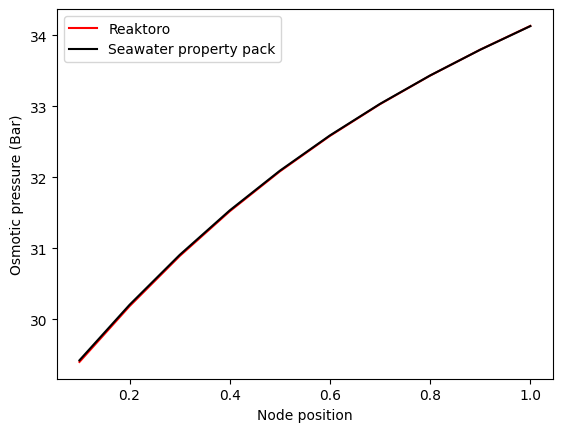

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

reaktoro_osm = []
sewater_prop_pack_osm = []
for idx in indexes:
    reaktoro_osm.append(
        float(m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"].value / 1e5)
    )
    """ recalc pressure from prop pack package"""
    calculate_variable_from_constraint(
        m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"],
        m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase["Liq"],
    )
    sewater_prop_pack_osm.append(
        float(m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"].value / 1e5)
    )

ax.plot(indexes, reaktoro_osm, color="red", label="Reaktoro")
ax.plot(
    indexes, sewater_prop_pack_osm, color="black", label=f"{prop_pack} property pack"
)
ax.set(xlabel="Node position", ylabel="Osmotic pressure (Bar)")
plt.legend()
plt.show()

Check other properties

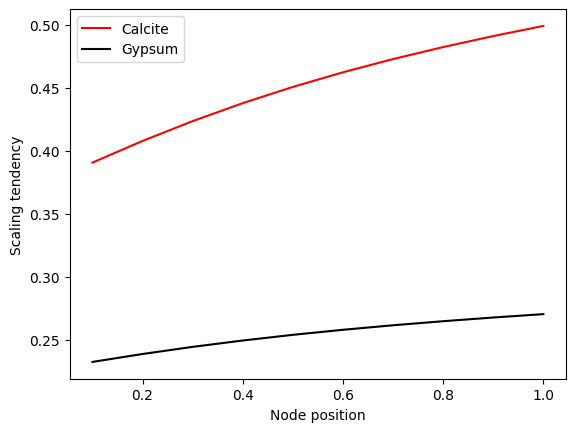

In [32]:
fig, ax = plt.subplots()

scaling_calcite = []
scaling_gypsum = []
for idx in indexes:
    scaling_calcite.append(
        float(m.fs.RO.indexed_outputs[idx, "scalingTendency", "Calcite"].value)
    )
    scaling_gypsum.append(
        float(m.fs.RO.indexed_outputs[idx, "scalingTendency", "Gypsum"].value)
    )
ax.plot(indexes, scaling_calcite, color="red", label="Calcite")
ax.plot(indexes, scaling_gypsum, color="black", label="Gypsum")
ax.set(xlabel="Node position", ylabel="Scaling tendency")
plt.legend()
plt.show()

Solve RO for higher recovery. 

In [33]:
print("Current recovery", m.fs.RO.recovery_vol_phase[0, "Liq"].value)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.50)
m.fs.pump.outlet.pressure[0].unfix()
result = cy_solver.solve(m, tee=True)
assert_optimal_termination(result)

Current recovery 0.2662990759628819
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3999
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      896

Total number of variables............................:     1049
                     variables with only lower bounds:      310
                variables with lower and upper bounds:      411
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1049
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   i

Plot comparison at higher recovery

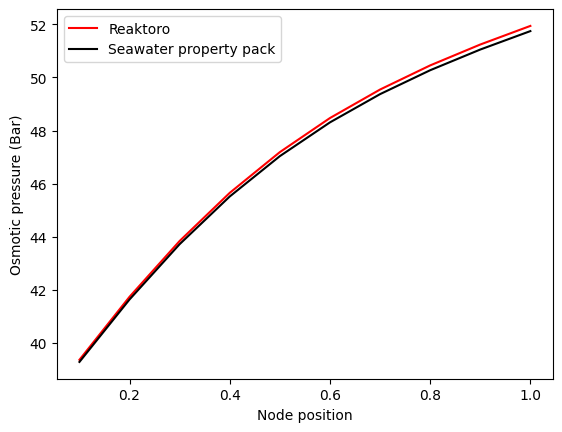

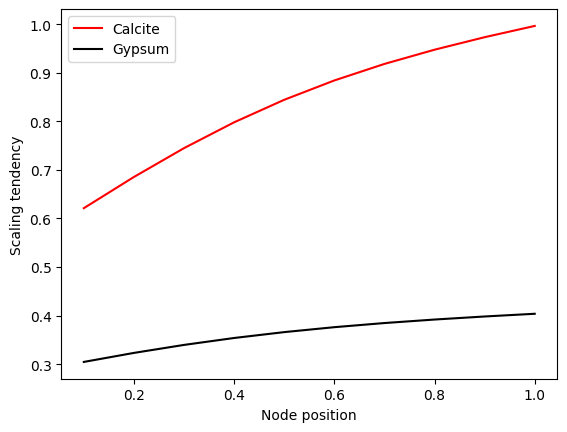

In [34]:
fig, ax = plt.subplots()

reaktoro_osm = []
sewater_prop_pack_osm = []
for idx in indexes:
    reaktoro_osm.append(
        float(m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"].value / 1e5)
    )
    calculate_variable_from_constraint(
        m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"],
        m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase["Liq"],
    )
    sewater_prop_pack_osm.append(
        float(m.fs.RO.indexed_outputs[idx, "osmoticPressure", "H2O"].value / 1e5)
    )

ax.plot(indexes, reaktoro_osm, color="red", label="Reaktoro")
ax.plot(
    indexes, sewater_prop_pack_osm, color="black", label=f"{prop_pack} property pack"
)
ax.set(xlabel="Node position", ylabel="Osmotic pressure (Bar)")
plt.legend()

fig, ax = plt.subplots()

scaling_calcite = []
scaling_gypsum = []
for idx in indexes:
    scaling_calcite.append(
        float(m.fs.RO.indexed_outputs[idx, "scalingTendency", "Calcite"].value)
    )
    scaling_gypsum.append(
        float(m.fs.RO.indexed_outputs[idx, "scalingTendency", "Gypsum"].value)
    )
ax.plot(indexes, scaling_calcite, color="red", label="Calcite")
ax.plot(indexes, scaling_gypsum, color="black", label="Gypsum")
ax.set(xlabel="Node position", ylabel="Scaling tendency")
plt.legend()
plt.show()